<font size="6"> Synthetic classification </font>

In the notebook we provide the figures for the Meta Learning experiment on a sequence of classification tasks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

from src_icml.simulations import generate_classification_tasks
from src_icml.learners_classification import OGA, mean_OPMS, OPMS

# Data

In [3]:
np.random.seed(42)

T, n, d = 500, 100, 10

mu = np.ones(d)*4 
r = 2.
run = 10

Xs = np.zeros((run,T,n,d))
ys = np.zeros((run,T,n))
coefs = np.zeros((run,T,d))

for i in range(run):
    Xs[i], ys[i], coefs[i] = generate_classification_tasks(mu = mu,T=T, n=n,r=r)
        
print(Xs.shape, ys.shape, coefs.shape)

(10, 500, 100, 10) (10, 500, 100) (10, 500, 10)


# Learning in isolation (I-OGA)

In [4]:
hinge_oga = np.zeros((run,T))      # store final hinge loss for each task
losses_oga = np.zeros((run, T, n)) # store evolution of the hinge loss for each task

for i in range(run):
    for t in range(T):
            oga = OGA(lr=1./np.sqrt(n))
            X,y = Xs[i,t], ys[i,t]
            oga.fit(X,y)
            coef = oga.coef_
            hinge = 1-X.dot(coef)*y
            hinge[hinge<0] = 0
            hinge_oga[i,t] = np.mean(hinge)
            losses_oga[i,t] = oga.losses_

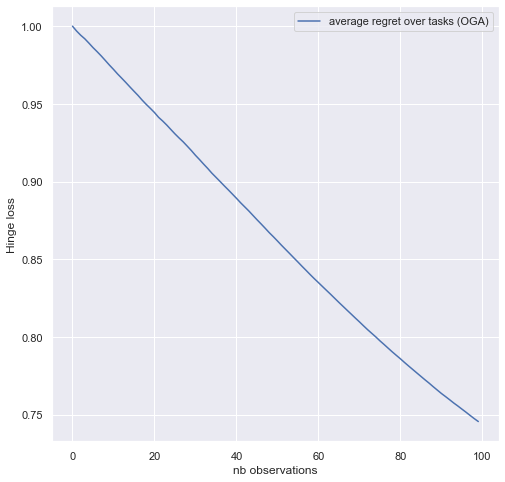

In [5]:
plt.figure(figsize=(8,8))
average_loss = losses_oga.mean(1).mean(0)
plt.plot(np.cumsum(average_loss)/(np.arange(average_loss.shape[0])+1),label="average regret over tasks (OGA)")

plt.xlabel("nb observations")
plt.ylabel("Hinge loss")
plt.legend()

plt.show()

$n=100$ observations is not enough for Online Gradient Descent to converge, we expect a substantial improvement with meta learning.

# Mean OPMS

**Inner OGA:** $\ell_{t, i}(\theta)=\left(1-y_{t, i}x_{t, i}^{T} \theta\right)_+$, $\nabla \ell_{t, i}(\theta)=-y_{t, i}x_{t, i}$ if $y_{t, i}x_{t, i}^{T} \theta \leq 1$ else $0$, $$\theta_{t,i} = \theta_{t,i-1} - \gamma \nabla \ell_{t, i}(\theta_{t,i-1})$$ $\gamma = 1/\sqrt{n}$


**Task specific loss:** $$F_t(\theta, \vartheta) = \sum_{i=1}^n \ell_{t,i}(\theta) + B_n(\theta, \vartheta) + \frac{\| \vartheta - \vartheta_{t-1}\|^2}{2 \alpha} = \sum_{i=1}^n \left(1-y_{t, i}x_{t, i}^{T} \theta\right)_+ + \frac{n \gamma \Gamma^2}{2} + \frac{\|\theta - \vartheta\|^2}{2 \gamma} + \frac{\|\vartheta - \vartheta_{t-1}\|^2}{2 \alpha}    $$

**Gradients:**

\begin{aligned}
\frac{\partial F_{t}}{\partial \theta} &=\sum_{i=1}^{n} \nabla \ell_{t, i}(\theta)+\frac{\theta-\vartheta}{\gamma} = \sum_{i=1}^{n}-y_{t, i}x_{t, i}1_{y_{t, i}x_{t, i}^{T} \theta \leq 1} + \frac{\theta-\vartheta}{\gamma}  \\
\frac{\partial F_{t}}{\partial \vartheta} &=\frac{\vartheta-\theta}{\gamma}+\frac{\vartheta-\vartheta_{t-1}}{\alpha}
\end{aligned}

In [6]:
%%time
# run meta algo
meta_weights = np.zeros((run,T,d))
save = []

for r in range(run):
    mean_OPMS_learner = mean_OPMS(lr = 1./np.sqrt(T), gamma=1./np.sqrt(n), steps=50)
    mean_OPMS_learner.fit(Xs[r],ys[r])
    meta_weights[r] = np.array(mean_OPMS_learner.mu_list_[:-1])

CPU times: user 44.5 s, sys: 158 ms, total: 44.6 s
Wall time: 44.7 s


In [7]:
%%time
hinge_mean_opms = np.zeros((run,T))

for i in range(run):
    for t in range(T):
        init = meta_weights[i,t]
        oga = OGA(lr=1./np.sqrt(n))
        X,y = Xs[i,t], ys[i,t]
        oga.fit(X,y, init=init)
        coef = oga.coef_
        hinge = 1-X.dot(coef)*y
        hinge[hinge<0] = 0
        hinge_mean_opms[i,t] = np.mean(hinge)

CPU times: user 2.92 s, sys: 13.5 ms, total: 2.94 s
Wall time: 2.94 s


# OPMS

**Task specific loss:** $$F_t(\theta, (\vartheta, \gamma)) = \sum_{i=1}^n \ell_{t,i}(\theta) + B_n(\theta, (\vartheta, \gamma)) + \frac{\| (\vartheta, \gamma) - (\vartheta, \gamma)_{t-1}\|^2}{2 \alpha} = \sum_{i=1}^n \left(1-y_{t, i}x_{t, i}^{T} \theta\right)_+ + \frac{n \gamma \Gamma^2}{2} + \frac{\|\theta - \vartheta\|^2}{2 \gamma} + \frac{\|\vartheta - \vartheta_{t-1}\|^2 + (\gamma - \gamma_{t-1})^2}{2 \alpha}    $$



\begin{aligned}
\frac{\partial F_{t}}{\partial \theta} &=\sum_{i=1}^{n} \nabla \ell_{t, i}(\theta)+\frac{\theta-\vartheta}{\gamma} = \sum_{i=1}^{n}-y_{t, i}x_{t, i}1_{y_{t, i}x_{t, i}^{T} \theta \leq 1} + \frac{\theta-\vartheta}{\gamma} \\
\frac{\partial F_{t}}{\partial \vartheta} &=\frac{\vartheta-\theta}{\gamma}+\frac{\vartheta-\vartheta_{t-1}}{\alpha} \\
\frac{\partial F_{t}}{\partial \gamma} &=\frac{\Gamma^{2} n}{2}-\frac{\|\theta-\vartheta\|^{2}}{2 \gamma^{2}}+\frac{\gamma-\gamma_{t-1}}{\alpha}
\end{aligned}

In [8]:
%%time
meta_weights = np.zeros((run,T,d))
meta_lr = np.zeros((run,T))

for r in range(run):
    OPMS_learner = OPMS(1./np.sqrt(T), L=.1, steps=100)
    OPMS_learner.fit(Xs[r],ys[r])
    meta_weights[r] = np.array(OPMS_learner.mu_list_[:-1])
    meta_lr[r] = np.array(OPMS_learner.gamma_list_[:-1])

CPU times: user 1min 33s, sys: 411 ms, total: 1min 34s
Wall time: 1min 34s


In [9]:
%%time
hinge_opms = np.zeros((run,T))

for r in range(run):
    for t in range(T):
            init = meta_weights[r,t]
            gamma = meta_lr[r,t]
            oga = OGA(lr=gamma)
            X,y = Xs[r,t], ys[r,t]
            oga.fit(X,y, init=init)
            coef = oga.coef_
            hinge = 1-X.dot(coef)*y
            hinge[hinge<0] = 0
            hinge_opms[r,t] = np.mean(hinge)

CPU times: user 2.97 s, sys: 28.9 ms, total: 3 s
Wall time: 3.01 s


# Results

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [16]:
def build_regret(l):
    r,n = l.shape
    return np.cumsum(l,axis=1)/np.tile(np.arange(1,n+1).reshape(-1,1),(1,r)).T

plt.figure(figsize=(12,6))
x = build_regret(hinge_mean_opms).mean(0)
ci = 1.96 * np.std(build_regret(hinge_mean_opms),0)/np.sqrt(run)
plt.plot(x,label="Mean OPMS",color='r')
plt.fill_between(range(T),(x-ci), (x+ci), color='r', alpha=.1)

x = build_regret(hinge_opms).mean(0)
ci = 1.96 * np.std(build_regret(hinge_opms),0)/np.sqrt(run)
plt.plot(x,label="OPMS",color='g')
plt.fill_between(range(T),(x-ci), (x+ci), color='g', alpha=.1)

plt.hlines(hinge_oga.mean(),0,T, label="I-OGA")

plt.xlabel("T")
plt.ylabel("Hinge Loss")
plt.legend()
plt.savefig('classification')
plt.show()